## Setup

In [ ]:
! pip install neuralogic
from neuralogic.nn import get_evaluator
from neuralogic.core import R, Template, V
from neuralogic.core.settings import Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 23.7 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Dataset definition

In [ ]:
_, dataset = Mutagenesis()

template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])


template.add_rules([
    (R.bond_embed(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])


## Subgraph network rules

In [ ]:
def get_sgn(max_order:int, layer_name: str, node_embed: str, edge_embed: str, 
            connection:str, param_size: tuple):
  template = []

  template += [R.get(f"{layer_name}_0")(V.B1, V.B2) <= (R.get(connection)(V.X, V.Y, V.B1), 
                                                        R.get(connection)(V.Y, V.Z, V.B2), 
                                                        R.get(edge_embed)(V.B1)[param_size], 
                                                        R.get(edge_embed)(V.B2)[param_size], 
                                                        R.get(node_embed)(V.X)[param_size], 
                                                        R.get(node_embed)(V.Y)[param_size], 
                                                        R.get(node_embed)(V.Z)[param_size])]

  for i in range(max_order):
    template += [R.get(f"{layer_name}_{i+1}")(V.X, V.Z) <= (R.get(f"{layer_name}_{i}")(V.X, V.Y)[param_size],
                                                            R.get(f"{layer_name}_{i}")(V.Y, V.Z)[param_size])]
  template += [R.get(layer_name)(V.X) <= R.get(f"{layer_name}_{max_order}")(V.X, V.Z)]

  return template




template += get_sgn(3, "l1", "atom_embed", "bond_embed", "bond", (3,3))



In [ ]:
# first order SGN
template += R.edge1(V.B1, V.B2) <= (R._bond(V.X, V.Y, V.B1), R._bond(V.Y, V.Z, V.B2), 
                                        R.bond_embed(V.B1)[3, 3], R.bond_embed(V.B2)[3, 3], 
                                        R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.atom_embed(V.Z)[3, 3])

# second order
template += R.edge2(V.X, V.Z) <= (R.edge1(V.X, V.Y)[3, 3], R.edge1(V.Y, V.Z)[3, 3])

# third order
template += R.edge3(V.X, V.Z) <= (R.edge2(V.X, V.Y)[3, 3], R.edge2(V.Y, V.Z)[3, 3])

Other kinds of subgraphs

In [ ]:
# two nodes in same cycle
def get_cycle(n):
    body = [R.bond(f"X{i}", f"X{(i+1) % n}", f"B{i}") for i in range(n)]
    body.extend(R.atom_embed(f"X{i}")[3, 3] for i in range(n))
    body.extend(R.bond_embed(f"B{i}")[3, 3] for i in range(n))
    body.append(R.special.alldiff(...))

    return R.cycle([f"X{i}" for i in range(n)]) <= body

def connect_cycle(n):
    return R.cycle([f"X{i}" for i in range(n-1)]) <= R.cycle([f"X{i}" for i in range(n)])

max_ring_size = 10
for i in range(3, max_ring_size):
    template += get_cycle(i)
    template += connect_cycle(i)


template += R.path(V.X, V.Y, 0) <= (R.bond_embed(V.B)[3, 3], R._bond(V.X, V.Y, V.B)) 
template += R.path(V.X, V.Y, V.T) <= (R.bond_embed(V.B)[3, 3], R.path(V.Z, V.Y, V.T1)[3, 3], R._bond(V.X, V.Z, V.B), R.special.next(V.T1, V.T))

max_depth = 5
template += (R.path(V.X, V.Y) <= (R.path(V.X, V.Y, max_depth)))

In [ ]:
template += R.double_bond_subgraph(V.C) <= (R.atom_embed(V.F)[3, 3], R.bond_embed(V.B)[3, 3], R.bond(V.C, V.F, V.B), R.b_2(V.B))

template += R.y_subgraph(V.X1, V.X2, V.X3, V.X4) <= (R.bond(V.X1, V.X2, V.B1), R.bond(V.X1, V.X3, V.B2), R.bond(V.X1, V.X4, V.B3),
                                                     R.bond_embed(V.B1), R.bond_embed(V.B2), R.bond_embed(V.B3),
                                                     R.atom_embed(V.X1), R.atom_embed(V.X2), R.atom_embed(V.X3), R.atom_embed(V.X4),
                                                     R.special.alldiff(...))
template += R.y_bond(V.X1, V.X2, V.X3, V.X4) <= (R.y_subgraph(V.X1, V.X2, V.X3, V.X4),
                                                 R.bond(V.X1, V.X2, V.B1), R.b_2(V.B1),
                                                 R.special.alldiff(...))

template += R.y_group(V.X1, V.X2, V.X3) <= (R.y_bond(V.Y1, V.Y2, V.X1, V.X2), R.y_bond(V.Z1, V.Z2, V.X2, V.X3),
                                            R.special.alldiff(...))






template += R.four_nbhood(V.X, V.X1, V.X2, V.X3, V.X4) <= (R.bond(V.X, V.X1, V.B1), R.bond(V.X, V.X2, V.B2),
                                                           R.bond(V.X, V.X3, V.B3), R.bond(V.X, V.X4, V.B4),
                                                           R.bond_embed(V.B1), R.bond_embed(V.B2), R.bond_embed(V.B3), R.bond_embed(V.B4),
                                                           R.atom_embed(V.X1), R.atom_embed(V.X2), R.atom_embed(V.X3), R.atom_embed(V.X4),
                                                           R.atom_embed(V.X),
                                                           R.special.alldiff(...))

template += R.three_nbhood(V.X, V.X1, V.X2, V.X3) <= (R.bond(V.X, V.X1, V.B1), R.bond(V.X, V.X2, V.B2),
                                                           R.bond(V.X, V.X3, V.B3),
                                                           R.bond_embed(V.B1), R.bond_embed(V.B2), R.bond_embed(V.B3),
                                                           R.atom_embed(V.X1), R.atom_embed(V.X2), R.atom_embed(V.X3),
                                                           R.atom_embed(V.X),
                                                           R.special.alldiff(...))

template += R.chiral_center(V.C) <= (R.c(V.C), R.atom_type(V.X1)[3, 3], R.atom_type(V.X2)[3, 3], R.atom_type(V.X3)[3, 3], R.atom_type(V.X4)[3, 3],
                                     R.bond(V.C, V.X1, V.B1), R.bond(V.C, V.X2, V.B2), R.bond(V.C, V.X3, V.B3), R.bond(V.C, V.X4, V.B4),
                                     R.bond_embed(V.B1)[3,3], R.bond_embed(V.B2)[3,3], R.bond_embed(V.B3)[3,3], R.bond_embed(V.B4)[3,3],
                                     R.atom_embed(V.X1)[3,3], R.atom_embed(V.X2)[3,3], R.atom_embed(V.X3)[3,3], R.atom_embed(V.X4)[3,3],
                                     R.special.alldiff(...))









template += R.n_c(V.X) <= (R.c(V.X))
template += R.heterocycle(V.X) <= (R.cycle(V.X, V.C)[3, 3], R.c(V.C), ~R.n_c(V.X))


max_depth = 10
template += (R._next(i, i + 1) for i in range(max_depth))

template.add_rules([
    (R.aliphatic_bond(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3"]
])

template += R.aliphatic_chain(V.X, V.Y) <= R.aliphatic_chain(V.X, V.Y, max_depth)
template += R.aliphatic_chain(V.X, V.Y, 0) <= (R.bond(V.X, V.Z, V.B), R.c(V.X), R.c(V.Y), R.b_1(V.B), R.bond_embed(V.B)[3, 3])
template += R.aliphatic_chain(V.X, V.Y, V.T) <= (R.bond(V.X, V.Z, V.B), R.c(V.X), R.bond_embed(V.B)[3, 3],
                                                 R.special.next(V.T1, V.T), R.aliphatic_chain(V.Z, V.Y, V.T1), R.aliphatic_bond(V.B)[3, 3])


template += R.brick(V.X) <= (R.atom_embed(V.Y1)[3, 3], R.bond_embed(V.B1)[3, 3], R.bond(V.X, V.Y1, V.B1), R.b_1(V.B1), 
                             R.atom_embed(V.Y2)[3, 3], R.bond_embed(V.B2)[3, 3], R.bond(V.Y1, V.Y2, V.B2), R.b_2(V.B1), 
                             R.atom_embed(V.Y3)[3, 3], R.bond_embed(V.B3)[3, 3], R.bond(V.Y2, V.Y3, V.B3), R.b_1(V.B1), 
                             R.atom_embed(V.X)[3, 3], R.bond_embed(V.B4)[3, 3], R.bond(V.Y3, V.X, V.B4), R.b_2(V.B1),
                             R.special.alldiff(...))

template += R.n_cycle(V.X, V.Y) <= R.cycle(V.X, V.Y)
template += R.bridge(V.X) <= (R.bond(V.X, V.Y, V.B1), R.bond(V.X, V.Z, V.B2),
                              ~R.n_cycle(V.X, V.X1), ~R.n_cycle(V.Y, V.Z), 
                              R.cycle(V.Y, V.Y1)[3, 3], R.cycle(V.Z, V.Z1)[3, 3],
                              R.bond_embed(V.B1)[3,3], R.bond_embed(V.B2)[3,3], R.atom_embed(V.X)[3,3],
                              R.special.alldiff(V.X, V.Y, V.Z))

template += R.shared_atom(V.X) <= (R.bond(V.X, V.Y, V.B1), R.bond(V.X, V.Z, V.B2),
                                  R.cycle(V.X, V.Y)[3, 3], R.cycle(V.X, V.Z)[3, 3], ~R.n_cycle(V.Y, V.Z),
                                  R.bond_embed(V.B1)[3, 3], R.bond_embed(V.B2)[3, 3], R.atom_embed(V.X)[3, 3],
                                  R.special.alldiff(...))

template.add_rules([
    (R.atom_type(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])



In [ ]:
template += R.double_bond_patterns(V.X) <= R.double_bond_subgraph(V.X)[3, 3]
template += R.double_bond_patterns(V.X) <= R.y_subgraph(V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.double_bond_patterns(V.X2) <= R.y_subgraph(V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.double_bond_patterns(V.X3) <= R.y_subgraph(V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.double_bond_patterns(V.X) <= R.y_bond(V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.double_bond_patterns(V.X2) <= R.y_bond(V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.double_bond_patterns(V.X3) <= R.y_bond(V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.double_bond_patterns(V.X) <= R.y_group(V.X1, V.X2, V.X3)[3, 3]
template += R.double_bond_patterns(V.X2) <= R.y_group(V.X1, V.X2, V.X3)[3, 3]
template += R.pattern(V.X) <= R.double_bond_patterns(V.X)[3, 3]


template += R.nbhood(V.X) <= R.four_nbhood(V.X, V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.nbhood(V.X1) <= R.four_nbhood(V.X, V.X1, V.X2, V.X3, V.X4)[3, 3]
template += R.nbhood(V.X) <= R.three_nbhood(V.X, V.X1, V.X2, V.X3)[3, 3]
template += R.nbhood(V.X1) <= R.three_nbhood(V.X, V.X1, V.X2, V.X3)[3, 3]
template += R.nbhood(V.X) <= R.chiral_center(V.X)[3, 3]
template += R.pattern(V.X) <= R.nbhood(V.X)[3, 3]

template += R.circular(V.X) <= R.brick(V.X)[3, 3]
template += R.circular(V.X) <= R.cycle(V.X, V.Y)[3, 3]
template += R.circular(V.X) <= R.heterocycle(V.X)[3, 3]
template += R.pattern(V.X) <= R.circular(V.X)[3, 3]

template += R.collective_pattern(V.X) <= R.aliphatic_chain(V.X)[3, 3]
template += R.collective_pattern(V.X) <= R.shared_atom(V.X)[3, 3]
template += R.collective_pattern(V.X) <= R.bridge(V.X)[3, 3]
template += R.pattern(V.X) <= R.collective_pattern(V.X)[3, 3]

template += R.subgraph_pattern(V.X) <= R.pattern(V.X)[3, 3]
template += R.subgraph_pattern(V.X) <= (R.pattern(V.X)[3, 3], R.pattern(V.Y)[3, 3], R.path(V.X, V.Y))
template += R.subgraph_pattern <= R.subgraph_pattern(V.X)[3, 3]

In [ ]:
template += R.predict[1, 3] <= (R.l1(V.X))
template += R.predict[1, 3] <= R.subgraph_pattern

In [ ]:
print(template)

{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
l1_0(B1, B2) :- bond(X, Y, B1), bond(Y, Z, B2), {3, 3} bond_embed(B1), {3, 3} bond_embed(B2), {3, 3} atom_embed(X), {3, 3} atom_embed(Y), {3, 3} atom_embed(Z).
l1_1(X, Z) :- {3, 3} l1_0(X, Y), {3, 3} l1_0(Y, Z).
l1_2(X, Z) :- {3, 3} l1_1(X, Y), {3, 3} l1_1(Y, Z).
l1_3(X, Z) :- {3, 3} l1_2(X, Y), {3, 3} l1_2(Y, Z).
l1(X) :- l1_3(X, Z).
cycle(X0, X1, X2) :- bond(X0, X1, B0), bond(X1, X2, B1), bond(X2, X0, B2), {3, 3} atom_embed(X0), {3, 3} atom_embed(X1), {3, 3} atom_embed(X2), {3, 3} bond_embed(B0), {3, 3} bond_embed(B1), {3, 3} bond_embed(B2), @alldiff(X1, X2, B1, B0, X0, B2).
cycle(X0, X1) :- cycle(X

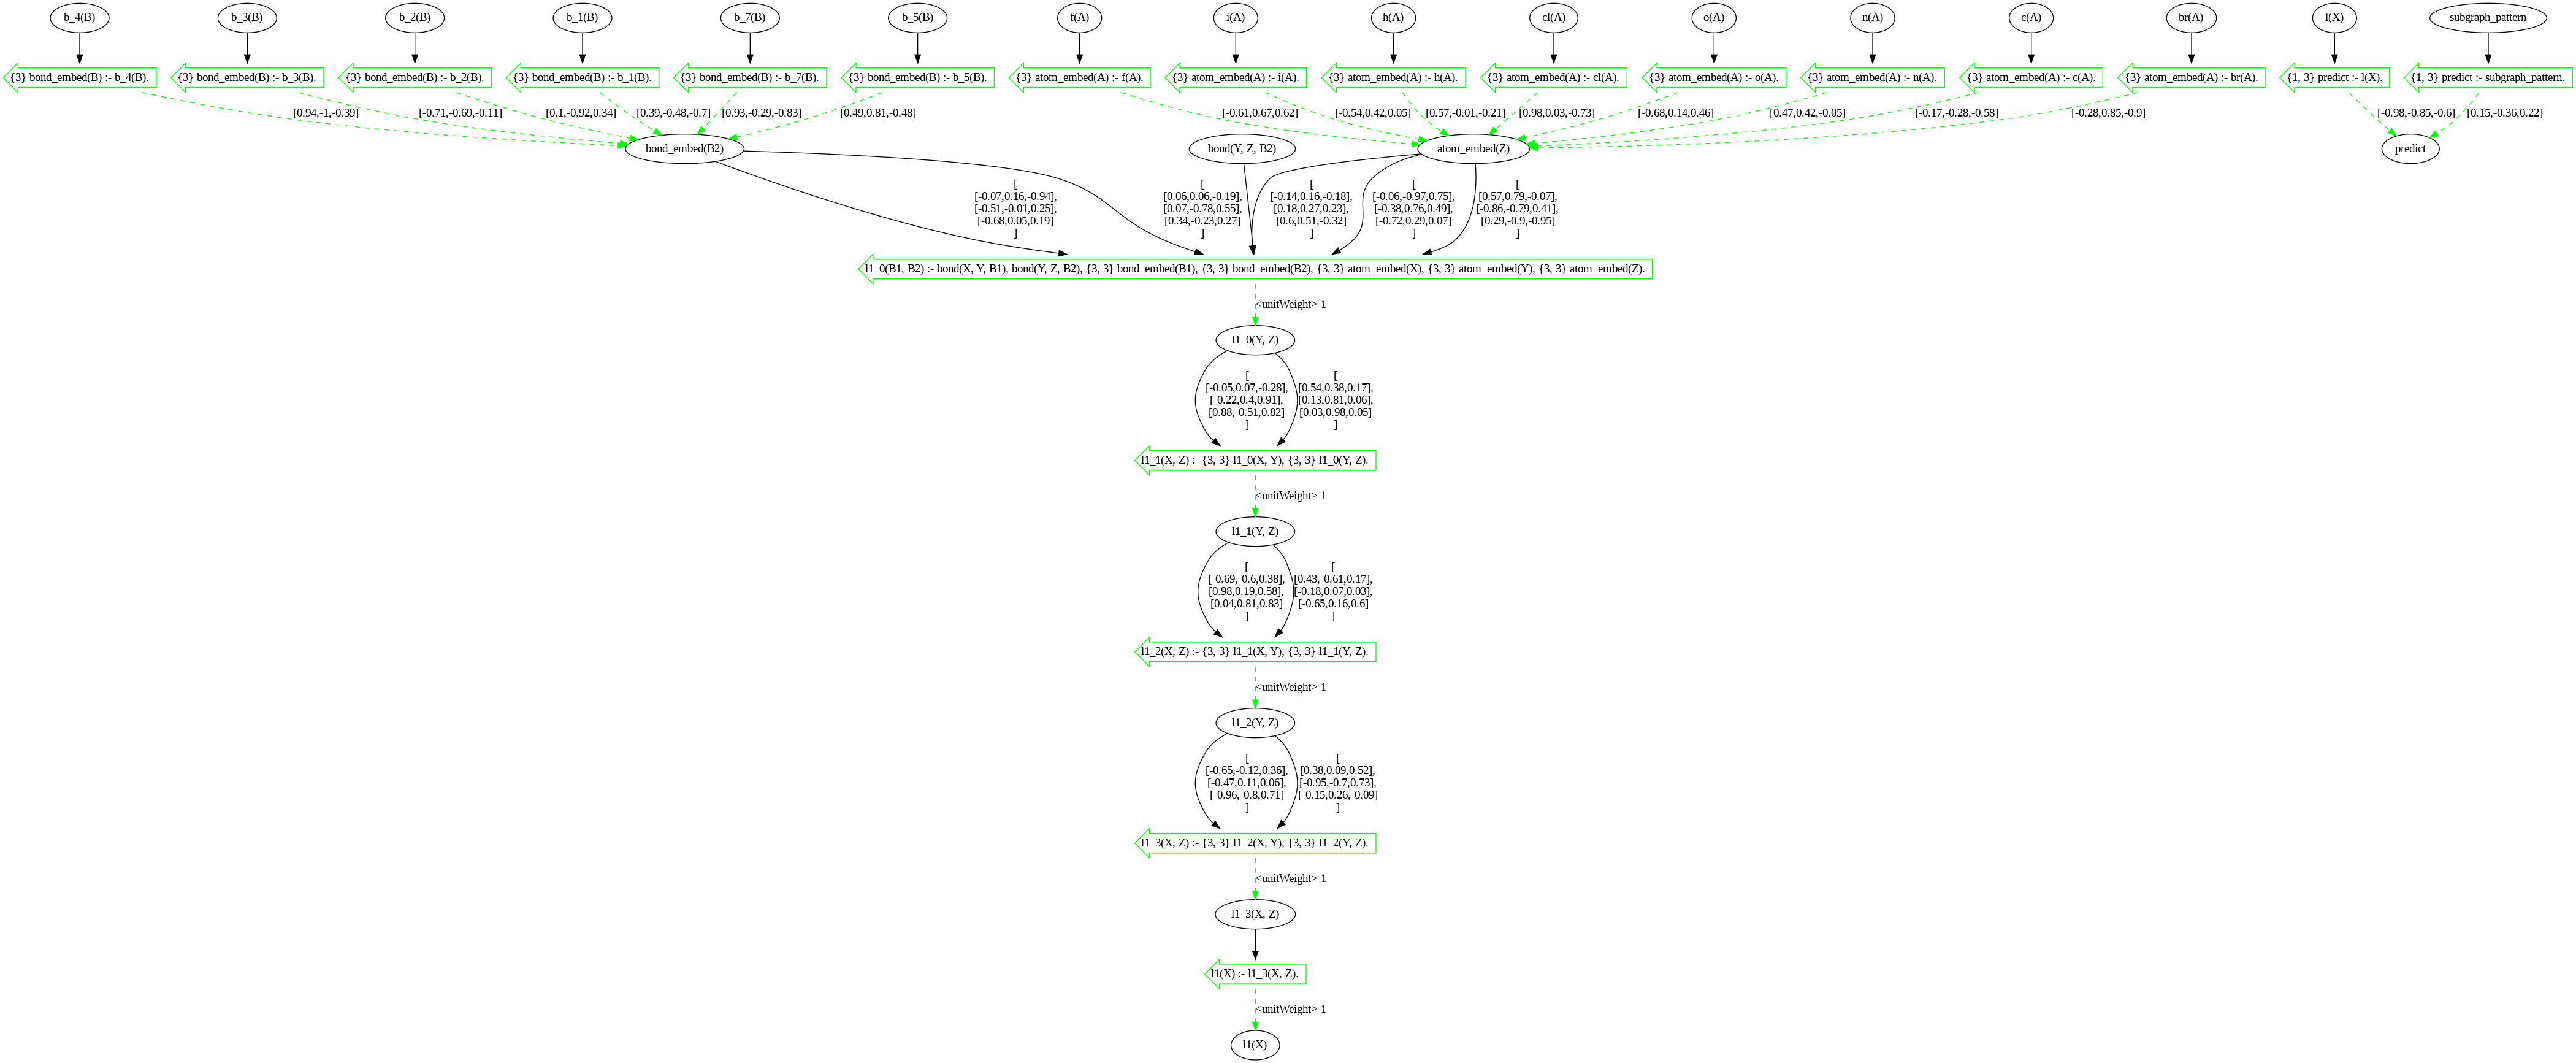

In [ ]:
template.draw()

## Training

In [ ]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_test_cycle(template, dataset, lr=0.001, epochs=100, split=0.75):
  settings = Settings(optimizer=Adam(lr=lr), epochs=epochs, error_function=MSE())
  evaluator = get_evaluator(template, settings)

  built_dataset = evaluator.build_dataset(dataset)
  dataset_len = len(built_dataset.samples)

  train_size = int(dataset_len*split)

  idx = random.sample(list(range(dataset_len)), train_size)
  rest = list(set(range(dataset_len)) - set(idx))
  train_dataset = np.array(built_dataset.samples)[idx]
  test_dataset = np.array(built_dataset.samples)[rest]
  average_losses = []

  for current_total_loss, number_of_samples in evaluator.train(train_dataset):
      clear_output(wait=True)
      plt.ylabel("Loss")
      plt.xlabel("Epoch")

      plt.xlim(0, settings.epochs)
      
      train_loss = current_total_loss/number_of_samples
      print(train_loss)

      average_losses.append(train_loss)
      
      plt.plot(average_losses, label="Average loss")

      plt.legend()
      plt.pause(0.001)
      plt.show()

  loss = []
  for sample, y_hat in zip(test_dataset, evaluator.test(test_dataset, generator=False)):
      loss.append(round(y_hat) != sample.java_sample.target.value)

  test_loss = sum(loss) / len(test_dataset)

  return train_loss, test_loss, evaluator


0.08315458226125284


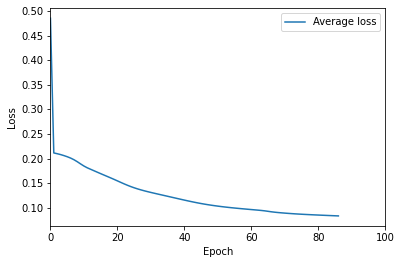

In [ ]:
test_losses = []
for i in range(1):
  print("Training and testing model #{}".format(i))
  train_loss, test_loss, eval = train_test_cycle(template, dataset)
  test_losses.append(test_loss)

np.average(test_losses)